# Домашнее задание 3

In [1]:
import re
import math
from collections import Counter
import string
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [245]:
with open('WarAndPeace.txt', 'r') as f:
    war_text_rus = f.read()
with open('WarAndPeaceEng.txt', 'r') as f:
    war_text_eng = f.read()
with open('AnnaKarenina.txt', 'r') as f:
    anna_text_rus = f.read()

In [246]:
war_text_rus = re.sub(r"\W+", " ", war_text_rus)
war_text_rus = war_text_rus.replace('  ', ' ').lower()
war_text_eng = re.sub(r"\W+", " ", war_text_eng)
war_text_eng = war_text_eng.replace('  ', ' ').lower()
anna_text_rus = re.sub(r"\W+", " ", anna_text_rus)
anna_text_rus = anna_text_rus.replace('  ', ' ').lower()

## Базовый частотный метод

In [256]:
def one_char_freq_encoder(origin_text, test_text):
    
    # считаем статистики на большом тексте
    freq_map = Counter()
    for char in origin_text:
        freq_map[char] += 1
    
    # перестановка сдигом на один символ
    encoder = dict()
    chars = list(freq_map.keys())
    for i in range(len(chars)):
        encoder[chars[i]] = chars[(i + 1) % len(chars)]
    
    # кодируем тестовый текст
    encoded_test = []
    for char in test_text:
        if char in encoder:
            encoded_test.append(encoder[char])
    test_text = ''.join(encoded_test)
    
    # считаем статистики на закодированном тексте
    fitted_map = Counter()
    for char in test_text:
        fitted_map[char] += 1
    
    # сортируем словари (символ: количество) по частоте вхождения
    fitted_map = sorted(list(fitted_map.items()), key=lambda x: x[1], reverse=True)
    freq_map = sorted(list(freq_map.items()), key=lambda x: x[1], reverse=True)
    
    # создаем декодер по принципу (самый частый символ -> самый частый символ) по убыванию
    decoder = dict()
    for i in range(len(fitted_map)):
        decoder[fitted_map[i][0]] = freq_map[i][0]
    
    # Проверяем какие символы расшифровались верно
    correct_decoded = []
    for char in decoder:
        if char == encoder[decoder[char]]:
            correct_decoded.append(decoder[char])
    return round(len(correct_decoded) / len(decoder), 3), correct_decoded

Запускаем несколько раз и усредняем. Получается, что точность пропорциональна логарифму длины тестого текста примерно до 30 000 символов. Дальнейшее его увеличение не дает прирост точности

In [263]:
acc_array = []
len_array = []
for len_test in [100, 300, 1000, 3000, 10000, 30000, 100000]:
    tmp_acc = []
    for start_idx in range(10000, 210001, 20000):
        test_text = war_text_eng[start_idx:start_idx+len_test]
        acc, _ = one_char_freq_encoder(war_text_eng, test_text)
        tmp_acc.append(acc)
    len_array.append(len_test)
    acc_array.append(sum(tmp_acc) / len(tmp_acc))

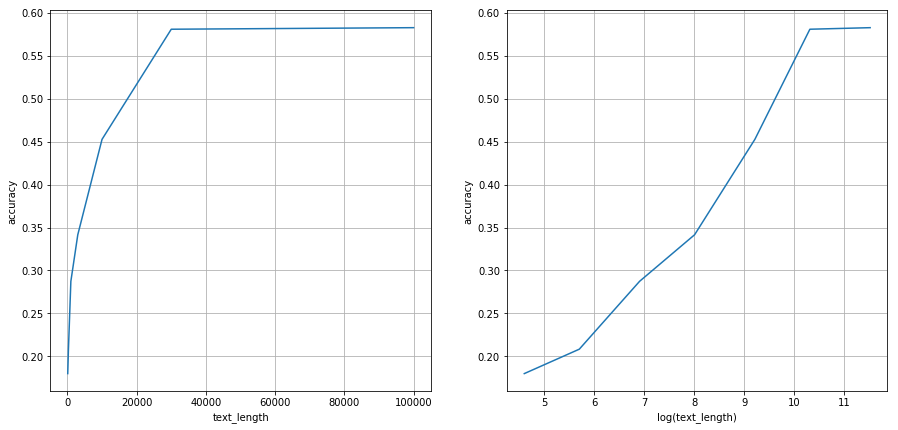

In [264]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(len_array, acc_array)
ax[0].grid()
ax[0].set_xlabel('text_length')
ax[0].set_ylabel('accuracy')
ax[1].plot([math.log(x) for x in len_array], acc_array)
ax[1].grid()
ax[1].set_xlabel('log(text_length)')
ax[1].set_ylabel('accuracy');

При тестировании на русском алфавите качетсво получилось хуже. Это логично, так как в русской версии обучающего текста встречаются латинские буквы, которые усложняют обучение и да и просто снижают Accuracy (плюс в качестве тестового текста использовался другой текст, а не отрывок обучающего)

In [259]:
acc_array = []
len_array = []
for len_test in [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]:
    tmp_acc = []
    for start_idx in range(10000, 210001, 20000):
        test_text = anna_text_rus[start_idx:start_idx+len_test]
        acc, _ = one_char_freq_encoder(war_text_rus, test_text)
        tmp_acc.append(acc)
    len_array.append(len_test)
    acc_array.append(sum(tmp_acc) / len(tmp_acc))

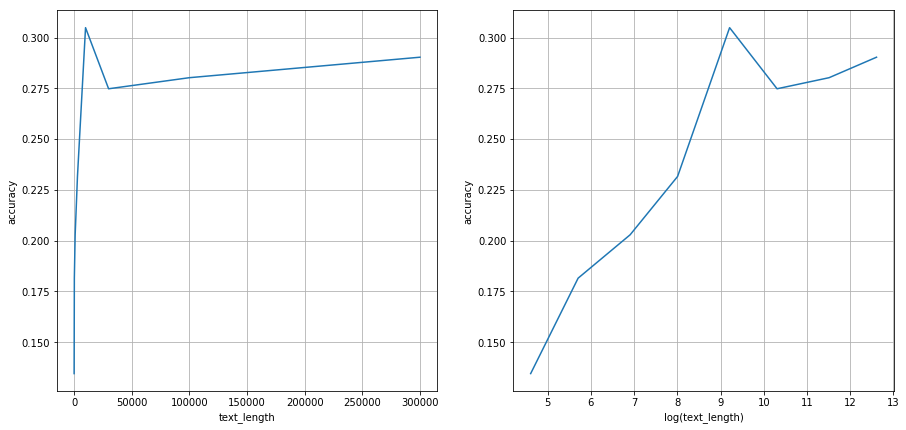

In [260]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(len_array, acc_array)
ax[0].grid()
ax[0].set_xlabel('text_length')
ax[0].set_ylabel('accuracy')
ax[1].plot([math.log(x) for x in len_array], acc_array)
ax[1].grid()
ax[1].set_xlabel('log(text_length)')
ax[1].set_ylabel('accuracy');

## Частотный метод на биграммах

In [267]:
def bigram_freq_encoder(origin_text, test_text):
    
    freq_map = Counter()
    for i in range(len(origin_text) - 1):
        pair = origin_text[i:i+2]
        freq_map[pair] += 1
            
    encoder = dict()
    chars = list(set(origin_text))
    for i in range(len(chars)):
        encoder[chars[i]] = chars[(i + 1) % len(chars)]
    
    encoded_test = []
    for char in test_text:
        if char in encoder:
            encoded_test.append(encoder[char])
    test_text = ''.join(encoded_test)
    
    fitted_map = Counter()
    for i in range(len(test_text) - 1):
        pair = test_text[i:i+2]
        fitted_map[pair] += 1
            
    fitted_map = sorted(list(fitted_map.items()), key=lambda x: x[1], reverse=True)
    freq_map = sorted(list(freq_map.items()), key=lambda x: x[1], reverse=True)
    
    # так как теперь каждый символ встресается в нескольких биграммах,
    # запоминаем первые 10 вариантов, начиная с более частых (могут повторяться)
    decoder = dict()
    chars = []
    for i in range(len(fitted_map)):
        for j in range(2):
            char = fitted_map[i][0][j]
            if char not in chars:
                chars.append(char)
            if char not in decoder:
                decoder[char] = Counter()
            if sum(decoder[char].values()) < 10:
                decoder[char][freq_map[i][0][j]] += 1
    
    # для кажого символа выбираем самый популярный вариант расшифровки (кроме уже занятых)
    used = []
    res_decoder = dict()
    for char in chars:
        for pair in decoder[char].most_common():
            if pair[0] not in used:
                res_decoder[char] = pair[0]
                used.append(pair[0])
                break
                
    correct_decoded = []
    for char in res_decoder:
        if char == encoder[res_decoder[char]]:
            correct_decoded.append(res_decoder[char])
            
    return round(len(correct_decoded) / len(decoder), 3), correct_decoded

При использовании биграмм зависимость точности от длины текста не такая стойкая и в целом качество заметно хуже

In [268]:
acc_array = []
len_array = []
for len_test in [1000, 3000, 10000, 30000, 100000]:
    tmp_acc = []
    for start_idx in range(10000, 210001, 20000):
        test_text = war_text_eng[start_idx:start_idx+len_test]
        acc, _ = bigram_freq_encoder(war_text_eng, test_text)
        tmp_acc.append(acc)
    len_array.append(len_test)
    acc_array.append(sum(tmp_acc) / len(tmp_acc))

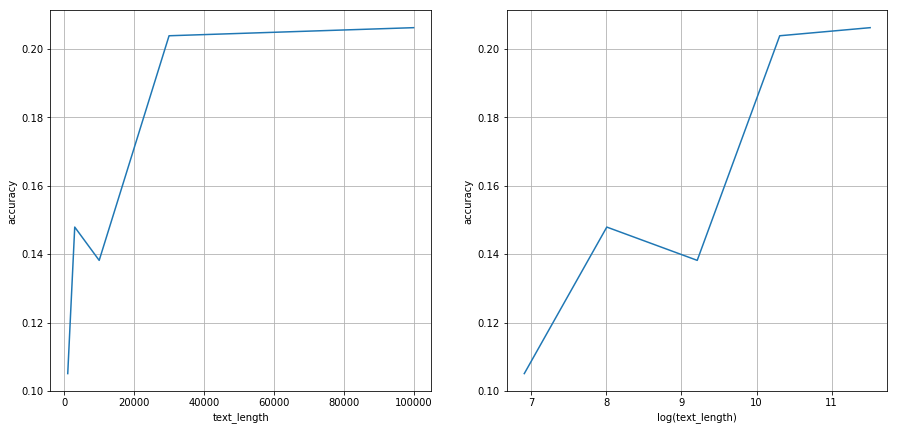

In [269]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(len_array, acc_array)
ax[0].grid()
ax[0].set_xlabel('text_length')
ax[0].set_ylabel('accuracy')
ax[1].plot([math.log(x) for x in len_array], acc_array)
ax[1].grid()
ax[1].set_xlabel('log(text_length)')
ax[1].set_ylabel('accuracy');

In [272]:
acc_array = []
len_array = []
for len_test in [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]:
    tmp_acc = []
    for start_idx in range(10000, 210001, 20000):
        test_text = anna_text_rus[start_idx:start_idx+len_test]
        acc, _ = bigram_freq_encoder(war_text_rus, test_text)
        tmp_acc.append(acc)
    len_array.append(len_test)
    acc_array.append(sum(tmp_acc) / len(tmp_acc))

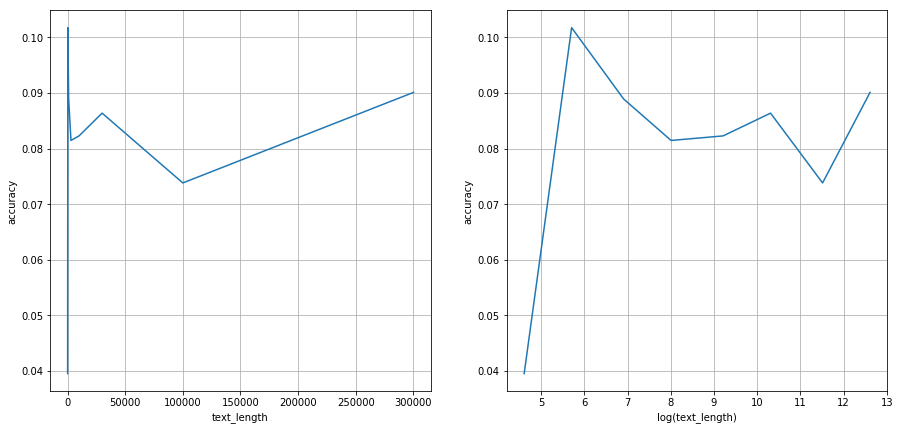

In [273]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(len_array, acc_array)
ax[0].grid()
ax[0].set_xlabel('text_length')
ax[0].set_ylabel('accuracy')
ax[1].plot([math.log(x) for x in len_array], acc_array)
ax[1].grid()
ax[1].set_xlabel('log(text_length)')
ax[1].set_ylabel('accuracy');

## Применение MCMC-сэмплирования

В качестве первой версии декодера возьмем тождественное преобразование. Один шаг - случайный swap двух символов декодера. На каждом шаге расшифровываем тестовое сообщение текущим и новым декодером. Если правдоподобие увеличилось, принимаем новый декодер, если нет - с вероятностью (новое / текущее)
Правдоподобие: p ~ p(bg1) * p(bg7) * p(bgi) ..., где каждый множитель соответсвует одной биграмме тетсового текста, двигаясь по одному символу - вероятность получить эту биграмму, обученная на основном тексте. Пусть всего биграмм M, а количество биграмм i в тестовом тексте N(i), тогда можно перписать 
p ~ (p(bg1)^N(1)) * (p(bg1)^N(1)) * ... * (p(bgM)^N(M))

In [275]:
def get_score(decoder, decoded_text, freq_map):
    
    # Расшифровываем текст полученным декодером
    decoded_text_arr = []
    for char in decoded_text:
        decoded_text_arr.append(decoder[char])
    decoded_text = ''.join(decoded_text_arr)
    
    # На получившемся тексте считаем количество биграмм
    fitted_map = Counter()
    for i in range(len(decoded_text) - 1):
        pair = decoded_text[i:i+2]
        fitted_map[pair] += 1
        
    score = 0
    for k, v in fitted_map.items():
        if k in freq_map:
            score += v * math.log(freq_map[k])
    return score

In [284]:
def mcmc_encoder(origin_text, test_text_len, idx_start):
    test_text = origin_text[idx_start:idx_start+test_text_len]

    freq_map = Counter()
    for i in range(len(origin_text) - 1):
        pair = origin_text[i:i+2]
        freq_map[pair] += 1
    
    # получаем частоту из количества
    for key in freq_map:
        freq_map[key] = freq_map[key] / len(origin_text)

    encoder = dict()
    chars = list(set(origin_text))
    for i in range(len(chars)):
        encoder[chars[i]] = chars[(i + 1) % len(chars)]

    for i in range(len(test_text)):
        test_text = test_text[:i] + encoder[test_text[i]] + test_text[i + 1:]
    
    # начальная версия декодера
    cur_decoder = dict()
    for c in chars:
        cur_decoder[c] = c

    best_score = -9999999999
    best_decoder = cur_decoder
    
    for i in range(500):
        # делаем случайную перестановку
        new_decoder = cur_decoder.copy()
        chars = list(new_decoder.keys())
        key_1 = random.choice(chars)
        chars.remove(key_1)
        key_2 = random.choice(chars)
        new_decoder[key_1], new_decoder[key_2] = new_decoder[key_2], new_decoder[key_1]

        cur_score = get_score(cur_decoder, test_text[:], freq_map)
        new_score = get_score(new_decoder, test_text[:], freq_map)
        
        diff = min(1, new_score - cur_score)
        prob = min(1, math.exp(diff))
        
        # сохраняем лучший декодер
        if new_score > best_score:
            best_score = new_score
            best_decoder = new_decoder
            
        # условие принятия нового декодера
        if prob >= random.uniform(0, 1):
            cur_decoder = new_decoder

        correct_decoded = []
        for char in cur_decoder:
            if char == encoder[cur_decoder[char]]:
                correct_decoded.append(cur_decoder[char])
        print(i, round(len(correct_decoded) / len(cur_decoder), 2), correct_decoded, prob)
    return best_decoder, encoder

Точность получается низкая

In [285]:
best_decoder, encoder = mcmc_encoder(war_text_eng, 10000, 30000)

0 0.0 [] 1
1 0.0 [] 1
2 0.0 [] 1.2013470794782624e-45
3 0.0 [] 1
4 0.02 ['t'] 1
5 0.02 ['t'] 0.0
6 0.02 ['t'] 0.0
7 0.02 ['t'] 1.1012586379495367e-78
8 0.02 ['t'] 0.0
9 0.02 ['t'] 5.163116473820605e-273
10 0.02 ['t'] 1
11 0.02 ['t'] 1
12 0.02 ['t'] 0.09992900498426487
13 0.02 ['t'] 1
14 0.02 ['t'] 1
15 0.02 ['t'] 0.0002941245272749226
16 0.02 ['t'] 1
17 0.02 ['t'] 6.430897046366905e-68
18 0.02 ['t'] 0.0
19 0.02 ['t'] 6.389868417919113e-286
20 0.02 ['t'] 1.749168826602144e-290
21 0.02 ['t'] 3.216342163624422e-153
22 0.02 ['t'] 0.0
23 0.02 ['t'] 1
24 0.02 ['t'] 1
25 0.02 ['t'] 7.25595978166976e-221
26 0.05 ['h', 't'] 1
27 0.05 ['h', 't'] 0.0
28 0.05 ['h', 't'] 1.452415377965092e-192
29 0.05 ['h', 't'] 0.0
30 0.05 ['h', 't'] 7.890397430036557e-21
31 0.05 ['h', 't'] 1
32 0.05 ['h', 't'] 0.0
33 0.05 ['h', 't'] 0.003806516763980787
34 0.05 ['h', 't'] 3.874515941831747e-48
35 0.05 ['h', 't'] 0.0
36 0.05 ['h', 't'] 1
37 0.05 ['h', 't'] 1
38 0.05 ['h', 't'] 0.0
39 0.05 ['h', 't'] 1
40 0.05 ['h'

359 0.02 ['k'] 0.0
360 0.02 ['k'] 3.5604009197724102e-171
361 0.02 ['k'] 1
362 0.02 ['k'] 1.2722544513163602e-139
363 0.02 ['k'] 0.0
364 0.02 ['k'] 1
365 0.02 ['k'] 1
366 0.02 ['k'] 0.0
367 0.02 ['k'] 1.2259277032242367e-125
368 0.02 ['k'] 0.0
369 0.02 ['k'] 0.0
370 0.02 ['k'] 2.47411202407281e-282
371 0.02 ['k'] 0.0
372 0.02 ['k'] 0.00020317076880512549
373 0.05 ['0', 'k'] 1
374 0.05 ['0', 'k'] 2.0678534598260712e-100
375 0.05 ['0', 'k'] 1.1000496080267217e-31
376 0.05 ['k', '0'] 1
377 0.05 ['0', 'k'] 1
378 0.05 ['0', 'k'] 3.4265970943048773e-54
379 0.05 ['k', '0'] 1
380 0.05 ['0', 'k'] 1
381 0.05 ['0', 'k'] 0.0
382 0.05 ['0', 'k'] 0.0
383 0.05 ['0', 'k'] 2.970757200179378e-86
384 0.05 ['0', 'k'] 0.0
385 0.05 ['0', 'k'] 3.7896259904629987e-72
386 0.05 ['0', 'k'] 3.431812975300909e-120
387 0.05 ['0', 'k'] 3.9529339436054525e-156
388 0.05 ['k', '0'] 1
389 0.05 ['k', '0'] 0.0
390 0.05 ['k', '0'] 0.0
391 0.05 ['k', '0'] 1.939918185041575e-209
392 0.05 ['k', '0'] 0.0
393 0.05 ['0', 'k'] 1


In [286]:
correct_decoded = []
for char in best_decoder:
    if char == encoder[best_decoder[char]]:
        correct_decoded.append(best_decoder[char])
print(round(len(correct_decoded) / len(best_decoder), 3), correct_decoded)

0.049 ['2', '0']


Алгоритм заработал при внесении двух изменений:
1. Не преобразовывать количества вхождений биграмм в основном тексте к частотам
2. Переходить только если правдоподобие увеличилось

In [295]:
def error_descent_encoder(origin_text, test_text_len, idx_start):
    test_text = origin_text[idx_start:idx_start+test_text_len]

    freq_map = Counter()
    for i in range(len(origin_text) - 1):
        pair = origin_text[i:i+2]
        freq_map[pair] += 1

    encoder = dict()
    chars = list(set(origin_text))
    for i in range(len(chars)):
        encoder[chars[i]] = chars[(i + 1) % len(chars)]

    for i in range(len(test_text)):
        test_text = test_text[:i] + encoder[test_text[i]] + test_text[i + 1:]

    cur_decoder = dict()
    for c in chars:
        cur_decoder[c] = c

    best_score = -9999999999
    best_decoder = cur_decoder
    
    for i in range(5000):
        new_decoder = cur_decoder.copy()
        chars = list(new_decoder.keys())
        key_1 = random.choice(chars)
        chars.remove(key_1)
        key_2 = random.choice(chars)
        new_decoder[key_1], new_decoder[key_2] = new_decoder[key_2], new_decoder[key_1]

        cur_score = get_score(cur_decoder, test_text[:], freq_map)
        new_score = get_score(new_decoder, test_text[:], freq_map)

        if new_score > best_score:
            best_score = new_score
            best_decoder = new_decoder
        if new_score > cur_score:
            cur_decoder = new_decoder

        correct_decoded = []
        for char in cur_decoder:
            if char == encoder[cur_decoder[char]]:
                correct_decoded.append(cur_decoder[char])
        print(i, round(len(correct_decoded) / len(cur_decoder), 2), correct_decoded)
    return best_decoder, encoder

Точность получилась высокая

In [296]:
best_decoder, encoder = error_descent_encoder(war_text_eng, 20000, 30000)

0 0.0 []
1 0.0 []
2 0.0 []
3 0.0 []
4 0.0 []
5 0.0 []
6 0.0 []
7 0.0 []
8 0.0 []
9 0.0 []
10 0.0 []
11 0.0 []
12 0.0 []
13 0.0 []
14 0.0 []
15 0.0 []
16 0.0 []
17 0.0 []
18 0.0 []
19 0.0 []
20 0.0 []
21 0.0 []
22 0.0 []
23 0.0 []
24 0.0 []
25 0.0 []
26 0.0 []
27 0.0 []
28 0.0 []
29 0.0 []
30 0.0 []
31 0.0 []
32 0.0 []
33 0.0 []
34 0.0 []
35 0.0 []
36 0.0 []
37 0.0 []
38 0.0 []
39 0.0 []
40 0.0 []
41 0.0 []
42 0.0 []
43 0.0 []
44 0.0 []
45 0.0 []
46 0.0 []
47 0.0 []
48 0.0 []
49 0.0 []
50 0.0 []
51 0.0 []
52 0.0 []
53 0.0 []
54 0.0 []
55 0.0 []
56 0.0 []
57 0.0 []
58 0.0 []
59 0.0 []
60 0.0 []
61 0.0 []
62 0.0 []
63 0.0 []
64 0.0 []
65 0.0 []
66 0.0 []
67 0.0 []
68 0.0 []
69 0.0 []
70 0.0 []
71 0.0 []
72 0.0 []
73 0.0 []
74 0.0 []
75 0.0 []
76 0.0 []
77 0.0 []
78 0.0 []
79 0.0 []
80 0.0 []
81 0.0 []
82 0.0 []
83 0.0 []
84 0.0 []
85 0.0 []
86 0.0 []
87 0.0 []
88 0.0 []
89 0.0 []
90 0.0 []
91 0.0 []
92 0.0 []
93 0.0 []
94 0.0 []
95 0.0 []
96 0.0 []
97 0.0 []
98 0.0 []
99 0.0 []
100 0.0 []

321 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
322 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
323 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
324 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
325 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
326 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
327 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
328 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
329 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
330 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
331 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
332 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
333 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
334 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
335 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
336 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
337 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
338 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
339 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
340 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
341 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
342 0.17 ['u', 'm', 'h', 'j', '4', 'a', 'n']
343 0.17 [

502 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
503 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
504 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
505 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
506 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
507 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
508 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
509 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
510 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
511 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
512 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
513 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
514 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
515 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
516 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
517 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
518 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
519 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
520 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
521 0.2 ['u', 'y', 'm', 'h', 'j', '4', 'a', 'n']
522 0.2 ['u', 'y', '

661 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
662 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
663 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
664 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
665 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
666 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
667 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
668 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
669 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
670 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
671 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
672 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
673 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
674 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
675 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
676 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
677 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
678 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
679 0.22 [

811 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
812 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
813 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
814 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
815 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
816 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
817 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
818 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
819 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
820 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
821 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
822 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
823 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
824 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
825 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
826 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
827 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
828 0.22 ['y', 'v', 'm', 'h', 'x', 'n', 'j', 'a', '4']
829 0.22 [

943 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'j', '4', 'b', ' ', 'n']
944 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'j', '4', 'b', ' ', 'n']
945 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'j', '4', 'b', ' ', 'n']
946 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
947 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
948 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
949 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
950 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
951 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
952 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
953 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
954 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
955 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
956 0.29 ['r', 'y', 'v', 'l', 'm', 'h', 'x', 'n', 'j', 'b', '4', ' ']
957 0.29 ['r', 'y', 

1048 0.34 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', '4', ' ', 't']
1049 0.34 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', '4', ' ', 't']
1050 0.34 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', '4', ' ', 't']
1051 0.34 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', '4', ' ', 't']
1052 0.32 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'j', 'b', ' ', 't', 'n']
1053 0.32 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'j', 'b', ' ', 't', 'n']
1054 0.32 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'j', 'b', ' ', 't', 'n']
1055 0.32 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'j', 'b', ' ', 't', 'n']
1056 0.32 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'j', 'b', ' ', 't', 'n']
1057 0.32 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'j', 'b', ' ', 't', 'n']
1058 0.32 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'j', 'b', ' ', 't', 'n']
1059 0.32 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'j', 'b', ' ', 't', 'n']
1060 0.32 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'x', 'j', 'b', ' ', 't

1160 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1161 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1162 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1163 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1164 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1165 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1166 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1167 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1168 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1169 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1170 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1171 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1172 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1173 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1174 0

1276 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1277 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1278 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1279 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1280 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1281 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1282 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1283 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1284 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1285 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1286 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1287 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1288 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1289 0.29 ['r', 'y', 'v', 'l', 'm', 'q', 'h', 'n', 'j', 'b', ' ', 't']
1290 0

1384 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1385 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1386 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1387 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1388 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1389 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1390 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1391 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1392 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1393 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1394 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1395 0.34 ['r', 'y', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1396 0.34 ['r', 'y', 'e', 'v

1479 0.39 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'g', 'q', 'h', 'j', 'b', ' ', 't', 'n']
1480 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1481 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1482 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1483 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1484 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1485 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1486 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1487 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1488 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1489 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l',

1565 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1566 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1567 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1568 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1569 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1570 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1571 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1572 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1573 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1574 0.41 ['o', 'r', 'y', 'c', 'e', 'v', 'l', 'm', 'q', 'h', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1575 0.41 ['o', 'r', 'y', 'c', 'e', 'v',

1648 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'q', 'h', 'z', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1649 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'q', 'h', 'z', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1650 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'q', 'h', 'z', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1651 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'q', 'h', 'z', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1652 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'q', 'h', 'z', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1653 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'q', 'h', 'z', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1654 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'q', 'h', 'z', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1655 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'q', 'h', 'z', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1656 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'q', 'h', 'z', 'x', 'n', 'j', 'b', ' ', 't', 'g']
1657 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 

1724 0.49 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 'q', 'h', 'z', 'x', 'w', 'j', 'b', ' ', 't', 'n']
1725 0.49 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 'q', 'h', 'z', 'x', 'w', 'j', 'b', ' ', 't', 'n']
1726 0.49 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 'q', 'h', 'z', 'x', 'w', 'j', 'b', ' ', 't', 'n']
1727 0.49 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 'q', 'h', 'z', 'x', 'w', 'j', 'b', ' ', 't', 'n']
1728 0.49 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 'q', 'h', 'z', 'x', 'w', 'j', 'b', ' ', 't', 'n']
1729 0.49 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 'q', 'h', 'z', 'x', 'w', 'j', 'b', ' ', 't', 'n']
1730 0.49 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 'q', 'h', 'z', 'x', 'w', 'j', 'b', ' ', 't', 'n']
1731 0.49 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 'q', 'h', 'z', 'x', 'w', 'j', 'b', ' ', 't', 'n']
1732 0.49 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 'q', 'h', 'z', 'x', 'w', 'j', 'b', ' ', 't', 'n']
1

1803 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1804 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1805 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1806 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1807 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1808 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1809 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1810 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1811 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1812 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1813 0.41 ['o', 'r', 'y', 'c', 'e', 'd',

1890 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1891 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1892 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1893 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1894 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1895 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1896 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1897 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1898 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1899 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
1900 0.41 ['o', 'r', 'y', 'c', 'e', 'd',

1978 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1979 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1980 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1981 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1982 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1983 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1984 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1985 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1986 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1987 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
1988 0.41 ['o', 'r', 'y', 'c', 'e', 'd',

2064 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2065 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2066 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2067 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2068 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2069 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2070 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2071 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2072 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2073 0.41 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't']
2074 0.41 ['o', 'r', 'y', 'c', 'e', 'd',

2148 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2149 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2150 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2151 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2152 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2153 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2154 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2155 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2156 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2157 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 

2227 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2228 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2229 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2230 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2231 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2232 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2233 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2234 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2235 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2236 0.46 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 

2302 0.49 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 's', 'h', 'z', 'n', 'w', 'j', 'b', ' ', 't', 'g']
2303 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2304 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2305 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2306 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2307 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2308 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2309 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2310 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', '

2373 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2374 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2375 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2376 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2377 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2378 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2379 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2380 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2381 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

2444 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2445 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2446 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2447 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2448 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2449 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2450 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2451 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2452 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

2515 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2516 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2517 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2518 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2519 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2520 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2521 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2522 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2523 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

2586 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2587 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2588 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2589 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2590 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2591 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2592 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2593 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2594 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

2658 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2659 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2660 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2661 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2662 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2663 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2664 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2665 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2666 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

2730 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2731 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2732 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2733 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2734 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2735 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2736 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2737 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2738 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

2801 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2802 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2803 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2804 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2805 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2806 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2807 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2808 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2809 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

2874 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2875 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2876 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2877 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2878 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2879 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2880 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2881 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2882 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

2946 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2947 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2948 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2949 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2950 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2951 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2952 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2953 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
2954 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

3018 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
3019 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
3020 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
3021 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
3022 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
3023 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
3024 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
3025 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', 'b', ' ', 't', 'n']
3026 0.51 ['o', 'r', 'y', 'c', 'e', 'd', 'v', 'l', 'm', 'g', 's', 'k', '

3089 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3090 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3091 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3092 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3093 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3094 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3095 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3096 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't

3155 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3156 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3157 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3158 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3159 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3160 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3161 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't', 'g']
3162 0.56 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'l', 'm', 's', 'f', 'h', 'z', 'n', 'w', 'j', 'b', 'a', ' ', 't

3217 0.63 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3218 0.63 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3219 0.63 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3220 0.63 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3221 0.63 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3222 0.63 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3223 0.63 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3224 0.63 ['o

3277 0.63 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3278 0.63 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3279 0.63 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3280 0.63 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3281 0.63 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3282 0.63 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3283 0.63 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'f', 'h', 'z', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3284 0.63 ['o

3336 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3337 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3338 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3339 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3340 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3341 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3342 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1'

3394 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3395 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3396 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3397 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3398 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3399 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3400 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1'

3451 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3452 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3453 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3454 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3455 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3456 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3457 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1'

3509 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3510 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3511 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3512 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3513 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3514 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1', 'a', ' ', 't', 'g']
3515 0.66 ['o', 'r', 'k', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 's', 'u', 'f', '8', 'h', 'z', 'n', 'w', 'j', 'b', '1'

3564 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3565 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3566 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3567 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3568 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3569 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3570 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

3617 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3618 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3619 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3620 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3621 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3622 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3623 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

3670 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3671 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3672 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3673 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3674 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3675 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3676 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

3724 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3725 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3726 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3727 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3728 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3729 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3730 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

3778 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3779 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3780 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3781 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3782 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3783 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3784 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

3831 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3832 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3833 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3834 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3835 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3836 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3837 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

3885 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3886 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3887 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3888 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3889 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3890 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3891 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

3938 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3939 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3940 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3941 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3942 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3943 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3944 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

3992 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3993 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3994 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3995 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3996 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3997 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
3998 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4046 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4047 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4048 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4049 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4050 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4051 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4052 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4099 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4100 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4101 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4102 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4103 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4104 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4105 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4153 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4154 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4155 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4156 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4157 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4158 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4159 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4206 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4207 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4208 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4209 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4210 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4211 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4212 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4259 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4260 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4261 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4262 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4263 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4264 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4265 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4312 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4313 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4314 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4315 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4316 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4317 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4318 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4365 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4366 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4367 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4368 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4369 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4370 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4371 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4419 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4420 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4421 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4422 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4423 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4424 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4425 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4473 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4474 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4475 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4476 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4477 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4478 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4479 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4526 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4527 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4528 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4529 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4530 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4531 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4532 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4579 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4580 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4581 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4582 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4583 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4584 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4585 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4633 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4634 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4635 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4636 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4637 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4638 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4639 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4686 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4687 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4688 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4689 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4690 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4691 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4692 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4740 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4741 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4742 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4743 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4744 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4745 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4746 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4793 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4794 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4795 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4796 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4797 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4798 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4799 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4847 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4848 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4849 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4850 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4851 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4852 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4853 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4901 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4902 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4903 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4904 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4905 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4906 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4907 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

4955 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4956 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4957 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4958 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4959 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4960 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l', 'm', 'g', 's', 'k', 'q', 'f', '8', 'h', 'z', 'x', 'w', 'j', '1', 'a', 'b', ' ', 't', 'n']
4961 0.71 ['o', 'r', 'u', 'y', 'c', 'e', 'd', 'v', 'i', 'p', 'l'

In [297]:
correct_decoded = []
for char in best_decoder:
    if char == encoder[best_decoder[char]]:
        correct_decoded.append(best_decoder[char])
print("Доля расшифрованных символов", round(len(correct_decoded) / len(best_decoder), 3))
print("Расшифрованные символы", sorted(correct_decoded))
print("Нерасшифрованные символы", sorted(list(set(best_decoder.keys()) - set(correct_decoded))))

Доля расшифрованных символов 0.707
Расшифрованные символы [' ', '1', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Нерасшифрованные символы ['0', '2', '3', '4', '5', '6', '7', '9', 'à', 'ä', 'é', 'ê']


## Расшифровка сообщения

Воспользуемся последним из описанных выше методов

In [301]:
def error_descent_encoder_secret(origin_text, test_text):
    
    freq_map = Counter()
    for i in range(len(origin_text) - 1):
        pair = origin_text[i:i+2]
        freq_map[pair] += 1
    
    # Подготовим множества символов
    rus_alf = [chr(c) for c in range(ord('а'), ord('а')+32)] + ['ё', ' ']
    secret_alf = list(set(test_text))
    secret_alf = secret_alf + [str(i) for i in range(len(rus_alf) - len(secret_alf))]

    # Начальная версия декодера
    cur_decoder = dict()
    for i in range(len(rus_alf)):
        cur_decoder[secret_alf[i]] = rus_alf[i]
    
    best_score = -9999999999
    prev_best_score = best_score
    best_decoder = cur_decoder
    i = 0
    while True:
        i += 1
        new_decoder = cur_decoder.copy()
        chars = list(new_decoder.keys())
        key_1 = random.choice(chars)
        chars.remove(key_1)
        key_2 = random.choice(chars)
        new_decoder[key_1], new_decoder[key_2] = new_decoder[key_2], new_decoder[key_1]

        cur_score = get_score(cur_decoder, test_text[:], freq_map)
        new_score = get_score(new_decoder, test_text[:], freq_map)

        if new_score > best_score:
            best_score = new_score
            best_decoder = new_decoder
        if new_score > cur_score:
            cur_decoder = new_decoder
    
        # Если за 5000 итераций скор не прибавился, выходим
        if i % 5000 == 0:
            if best_score == prev_best_score:
                break
            prev_best_score = best_score

    for j in range(len(test_text)):
        test_text = test_text[:j] + best_decoder[test_text[j]] + test_text[j + 1:]
    print(i, best_score, test_text[:7])
    return best_decoder, test_text

Во время работы с сообщением была получена корректная расшифровка. Так как получать ее стабильно не получается, будем проводить итерации, пока не получим нужное начало сообщения

In [302]:
secret_text = 'დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ'

In [307]:
while True:
    best_decoder, decoded_text = error_descent_encoder_secret(war_text_rus, secret_text)
    if decoded_text[:7] == 'если вы':
        break

10000 1556.7606276908368 кто нья
10000 1657.2677530225983 ниям ст
10000 1626.1675852816895 нротекл
10000 1675.1070310661955 лков гр
10000 1604.7872772851306 етиднаш
10000 1600.0893056556242 сдертуй
10000 1627.3722790081554 траледп
10000 1620.607198574549 есотнал
10000 1584.8021795373545 еястназ
10000 1774.4975540365947 евни зь
10000 1615.2917163384234 сдетния
10000 1734.5915495426382 енси мл
15000 1777.1110368800385 еули вы
10000 1672.4853123240912 нкор пл
10000 1678.442169661486 тдивосп
15000 1608.9990358138657 втернуш
10000 1634.0883325165653 едитняз
10000 1649.057795641526 тди оюл
15000 1673.7296359021386 исноему
10000 1682.6599116330813 лков ст
10000 1625.213967678112 нситеюб
10000 1686.8705403187562 ндев зм
10000 1782.9983633804143 ерли ты
15000 1784.8074356304312 евни сь
10000 1622.9720495681227 ндесову
15000 1670.2720661902588 евин ст
10000 1763.0978763756343 евна зь
10000 1682.5559209916687 нкот сз
10000 1594.018179761542  тосназ
10000 1588.5830926108865 ласвитр
10000 1752.6604

In [308]:
decoded_text

'если вы вимите норжальный или подти норжальный текст у этого сообщения который легко продитать скорее всего вы все смелали правильно и полудите жаксижальный балл ча послемнее детвертое чамание курса зотя конедно я нидего не обещаш'